## Summary: Исследование и обучение модели рекомендаций

### Цель:
Построить рекомендательную модель, которая предсказывает посты, на которые пользователь с наибольшей вероятностью поставит лайк, с применением машинного обучения и обогащением признаков.

---

### Основные шаги:

1. **Исследование и подготовка данных:**
   - Объединены данные о пользователях, постах и взаимодействиях.
   - Добавлены временные признаки (день недели, час) и TF-IDF/LightGCN/трансформерные эмбеддинги.

2. **Формирование обучающей выборки:**

3. **Обучение моделей:**
   - Использован **CatBoostClassifier**.
   - Метрики: ROC AUC = **0.812**, Hitrate@5 ≈ **0.706**.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

In [3]:
import torch

torch.cuda.empty_cache()
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

## Метрики

In [5]:
from sklearn.metrics import roc_auc_score

# ROC AUC

def calculate_auc(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred)
    return score

# HitRate@N
def calculate_hit_rate_by_user(model, X_test, y_test, top_n=5):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    X_test = X_test.reset_index()
    y_test = y_test.reset_index(drop=True)

    results = pd.DataFrame({
        'user_id': X_test['user_id'],
        'y_true': y_test,
        'y_pred': y_pred_proba
    })

    hit_rate_by_user = (
        results.groupby('user_id')
        .apply(lambda group: (group.sort_values('y_pred', ascending=False).iloc[:top_n]['y_true'] == 1).any())
        .mean()
    )

    return hit_rate_by_user


## Загрузка данных и подготовка фич

### Таблица с постами post_text_df
Отбираем посты с 500+ лайков

SQL запрос  
```sql
create table nechetnaya_posts_dl as
(
select *   
from post_text_df   
where post_id in (select post_id from nechetnaya_popular)
)
```


In [ ]:
post_data = pd.read_csv('/kaggle/input/popular-posts-500/post_data_dl_500.csv')
post_data.head()

In [ ]:
post_data.shape

In [ ]:
# Получаем эмбединги из текста постов с помощью `all-MiniLM-L6-v2`

from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

texts = post_data['text'].tolist()

embeddings = model.encode(
    texts,
    show_progress_bar=True,
    batch_size=64,
    device=device, 
    convert_to_tensor=True 
)

torch.save(embeddings, "embeddings_MiniLM_dl.pt")

embeddings_df = pd.DataFrame(embeddings.cpu().numpy(), columns=[f'emb_{i}' for i in range(embeddings.shape[1])])



In [ ]:
#all-MiniLM-L6-v2
# уменьшим размерность эмбедингов - оценим дисперсию

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=384, random_state=42)
svd.fit(embeddings_df)

cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

plt.plot(range(1, 385), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% дисперсии')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% дисперсии')
plt.xlabel("Число компонент")
plt.ylabel("Накопленная доля объяснённой дисперсии")
plt.title("Truncated SVD: объяснённая дисперсия")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
svd = TruncatedSVD(n_components=200, random_state=42)

svd_embeddings = svd.fit_transform(embeddings_df)

post_embeddings_df = pd.DataFrame(svd_embeddings, columns=[f'svd_{i}' for i in range(svd_embeddings.shape[1])])

print(post_embeddings_df.shape)

In [ ]:
#Посчитаем длинну текста в символах и словах, сложность текста (по средней длине слов) 

post_data['log_text_len'] = np.log1p(post_data['text'].apply(len))
post_data['n_words'] = post_data['text'].apply(lambda x: len(str(x).split()))
post_data['avg_word_len'] = post_data['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0
)
post_data.head()

Посчитаем количество лайков у постов like_count_log, рейтинг like_rank и отношение лайков в к просмотрам like_score

```sql

with actions as   
(SELECT   
    post_id,   
    COUNT(*) FILTER (WHERE target = 0) AS views,  
    COUNT(*) FILTER (WHERE target = 1) AS likes  
FROM feed_data   
WHERE post_id IN (  
    SELECT post_id FROM nechetnaya_popular_posts  
)  
GROUP BY post_id)  
select   
    post_id,  
    views,  
    likes,  
    LOG(1 + likes) AS like_count_log,  
    DENSE_RANK() OVER (ORDER BY likes DESC) AS like_rank,  
    likes * 1.0 / NULLIF((views + likes), 0) AS like_score  
FROM actions
```


In [ ]:
post_score = pd.read_csv('/kaggle/input/posts-score-dl/posts_score_dl.csv')
post_score.head()

In [ ]:
posts_with_embeddings = pd.concat([post_data.reset_index(drop=True), post_embeddings_df], axis=1)
posts_with_embeddings.shape

In [ ]:
post_features = posts_with_embeddings.merge(
    post_score[['post_id', 'like_count_log', 'like_rank', 'like_score']],
    how='left',
    on='post_id'
)

post_features.drop('text', axis=1, inplace=True)
post_features.shape

In [ ]:
post_data

In [ ]:
#Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(post_data['text'])


svd = TruncatedSVD(n_components=100) 
X_reduced = svd.fit_transform(X)

X_reduced_df = pd.DataFrame(
    X_reduced,
    columns=[f'tfidf_{i}' for i in range(X_reduced.shape[1])]
)
X_reduced_df['post_id'] = post_data['post_id'].values
X_reduced_df.shape

In [ ]:
post_features = post_features.merge(
    X_reduced_df,
    how='left',
    on='post_id'
)

post_features.shape

In [ ]:
post_features.columns


In [ ]:
ohe = pd.get_dummies(post_features['topic'], prefix='topic', drop_first=True)
post_features = pd.concat([post_features.drop(columns='topic'), ohe], axis=1)
post_features.columns

In [ ]:
post_features.to_csv('post_features_dl_08_07.csv', index=False)

### Таблица с пользователями user_data

In [ ]:
user_data = pd.read_csv('/kaggle/input/user-data/user_data.csv')
print(user_data.shape, user_data.head())

In [ ]:
user_data = user_data.drop(['os', 'source'], axis=1)

In [ ]:
user_data.info()

In [ ]:
user_data.nunique()

In [ ]:
user_views_likes = pd.read_csv('/kaggle/input/user-views-likes/user_views_likes.csv')
print(user_views_likes.shape, user_views_likes.head())

In [ ]:
user_topics = pd.read_csv('/kaggle/input/user-topics/user_topics.csv')
print(user_topics.shape, user_topics.head())

In [ ]:
user_post_len = pd.read_csv('/kaggle/input/user-post-len/user_post_len.csv')
print(user_post_len.shape, user_post_len.head())

In [ ]:
user_features = (
    user_data
    .merge(user_post_len, how='left',on='user_id')
    .merge(user_topics,how='left',on='user_id')
    .merge(user_views_likes,how='left',on='user_id')
)

user_features.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse=False, dtype=int)

X_ohe = encoder.fit_transform(user_features[['country', 'exp_group']])

ohe_df = pd.DataFrame(
    X_ohe,
    columns=encoder.get_feature_names_out(['country', 'exp_group']),
)


ohe_df['user_id'] = user_features['user_id'].values


# Объединяем с другими колонками (если нужно)
user_features = pd.concat([
    user_features.drop(columns=['country', 'exp_group']),
    ohe_df.drop(columns=['user_id']) 
], axis=1)

user_features.columns

In [ ]:
freq = user_features['city'].value_counts(normalize=True)
user_features['city_freq'] = user_features['city'].map(freq)

user_features.columns

In [ ]:
user_features = user_features.drop('city', axis=1)

In [ ]:
user_features.to_csv('user_features_dl_08_07.csv', index=False)

##### Таблица feed_data
Загрузим 5 млн примеров по популярным постам, добавим фичи по дате и времени
```sql
select timestamp, user_id, post_id, target
from feed_data
where action = 'view' and post_id in (select post_id from nechetnaya_popular)
limit 5000000;
```

In [ ]:
import glob

file_list = sorted(glob.glob("/kaggle/input/feed-data-dl/feed_data_dl*.csv"))
feed_data = pd \
    .concat([pd.read_csv(file) for file in file_list], ignore_index=True)\
    .sort_values('timestamp')

print(feed_data.shape, feed_data.head())

In [ ]:
#убираем дубликаты просмотров


feed_data = (
    feed_data.sort_values(by="target", ascending=False)
    .drop_duplicates(subset=["user_id", "post_id"], keep="first")
    .sort_values(by="timestamp")
)
feed_data.shape

In [ ]:
feed_data.target.value_counts()[0] / feed_data.target.value_counts()[1]

In [ ]:
feed_data['timestamp'] = pd.to_datetime(feed_data['timestamp'], format="%d/%m/%y %H:%M", dayfirst=True)

In [ ]:
feed_data['weekday'] = feed_data['timestamp'].dt.dayofweek
feed_data['hour'] = feed_data['timestamp'].dt.hour


feed_data.head()

In [ ]:
feed_data.to_csv('feed_data_dl_08_07.csv', index=False)

## Эмбединги LightGCN 

In [ ]:
import glob

file_list = sorted(glob.glob("/kaggle/input/likes-months/likes_*.csv"))
likes = pd \
    .concat([pd.read_csv(file) for file in file_list], ignore_index=True)

print(likes.shape, likes.head())

In [ ]:
import torch
from scipy.sparse import coo_matrix

interactions = likes

user2id = {uid: i for i, uid in enumerate(interactions['user_id'].unique())}
post2id = {pid: i for i, pid in enumerate(interactions['post_id'].unique())}

interactions['user_idx'] = interactions['user_id'].map(user2id)
interactions['post_idx'] = interactions['post_id'].map(post2id)

num_users = len(user2id)
num_items = len(post2id)

R = coo_matrix(
    (np.ones(len(interactions)), (interactions['user_idx'], interactions['post_idx'])),
    shape=(num_users, num_items)
)

In [ ]:
import torch.nn as nn

class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, n_layers=3):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def forward(self, edge_index):
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight

        all_emb = torch.cat([user_emb, item_emb], dim=0) 
        embeddings = [all_emb]

        for _ in range(self.n_layers):
            edge_src, edge_dst = edge_index
            messages = all_emb[edge_dst]
            agg = torch.zeros_like(all_emb)
            agg.index_add_(0, edge_src, messages)
            all_emb = agg / (agg != 0).sum(dim=1, keepdim=True).clamp(min=1) 
            embeddings.append(all_emb)

        final_emb = sum(embeddings) / len(embeddings)
        return final_emb[:self.num_users], final_emb[self.num_users:]


In [ ]:
# Преобразуем матрицу R в edge_index для GCN
edge_u = torch.tensor(interactions['user_idx'].values, dtype=torch.long)
edge_i = torch.tensor(interactions['post_idx'].values + num_users, dtype=torch.long)

edge_index = torch.stack([torch.cat([edge_u, edge_i]), torch.cat([edge_i, edge_u])], dim=0)

model = LightGCN(num_users=num_users, num_items=num_items, embedding_dim=64, n_layers=3)

user_emb, item_emb = model(edge_index)


In [ ]:
# user_emb: [num_users, 64]
# item_emb: [num_items, 64]

user_embeddings = pd.DataFrame(user_emb.detach().numpy())
user_embeddings['user_id'] = [uid for uid, _ in sorted(user2id.items(), key=lambda x: x[1])]

item_embeddings = pd.DataFrame(item_emb.detach().numpy())
item_embeddings['post_id'] = [pid for pid, _ in sorted(post2id.items(), key=lambda x: x[1])]


In [ ]:

user_embeddings.columns = [f'user_emb_{i}' for i in range(user_embeddings.shape[1] - 1)] + ['user_id'] 

user_embeddings.head()

In [ ]:
user_features_full = user_features.merge(user_embeddings, on='user_id', how='left')
user_features_full.shape

In [ ]:
user_features_full.to_csv('user_features_full_dl_0807.csv', index=False)

In [ ]:
item_embeddings.columns = [f'item_emb_{i}' for i in range(item_embeddings.shape[1] - 1)] + ['post_id'] 
post_features_full = post_features.merge(item_embeddings, on='post_id', how='left')
post_features_full.shape

In [ ]:
post_features_full.to_csv('post_features_full_dl_0807.csv', index=False)

### Сборка датасета для трейна

In [ ]:
user_features = pd.read_csv('/kaggle/input/features-dl/user_features_full_dl_0807.csv')
post_features = pd.read_csv('/kaggle/input/features-dl/post_features_full_dl_0807.csv')
feed_data = pd.read_csv('/kaggle/input/features-dl/feed_data_dl_08_07.csv')

In [ ]:
for col in user_features.columns:
    if user_features[col].dtype == 'float64':
        user_features[col] = pd.to_numeric(user_features[col], downcast='float')
    elif user_features[col].dtype == 'int64':
        user_features[col] = pd.to_numeric(user_features[col], downcast='integer')


In [ ]:
for col in post_features.columns:
    if post_features[col].dtype == 'float64':
        post_features[col] = pd.to_numeric(post_features[col], downcast='float')
    elif post_features[col].dtype == 'int64':
        post_features[col] = pd.to_numeric(post_features[col], downcast='integer')

post_features.info()

In [ ]:
for col in feed_data.columns:
    if feed_data[col].dtype == 'float64':
        feed_data[col] = pd.to_numeric(feed_data[col], downcast='float')
    elif feed_data[col].dtype == 'int64':
        feed_data[col] = pd.to_numeric(feed_data[col], downcast='integer')

feed_data.drop('timestamp', axis=1)
feed_data.info()

In [ ]:
chunk_size = 500_000
result_chunks = []

for i in range(0, len(feed_data), chunk_size):
    chunk = feed_data.iloc[i:i+chunk_size]
    merged_chunk = (
        chunk.merge(user_features, how='left', on='user_id')
             .merge(post_features, how='left', on='post_id')
    )
    result_chunks.append(merged_chunk)

train_data = pd.concat(result_chunks)

train_data.shape

In [ ]:
for col in train_data.select_dtypes(include=["bool", "int8", "int16"]).columns:
    train_data[col] = train_data[col].astype("float32")


In [ ]:
def save_parquet_in_chunks(df: pd.DataFrame, path_prefix: str, chunk_size: int = 1_000_000):
    num_chunks = (len(df) + chunk_size - 1) // chunk_size
    for i in range(num_chunks):
        chunk = df.iloc[i*chunk_size : (i+1)*chunk_size]
        chunk.to_parquet(f"{path_prefix}_part{i:03d}.parquet", index=True)

save_parquet_in_chunks(train_data, "train_data", chunk_size=500_000)

In [ ]:
train_data.head()

## Обучение DL

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split

# ==== 1. PyTorch Dataset ====
class FeatureDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
        self.feature_cols = [col for col in df.columns if col not in ("user_id", "post_id", "target")]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = torch.tensor(row[self.feature_cols].values, dtype=torch.float32)
        y = torch.tensor(row["target"], dtype=torch.float32)
        uid = row["user_id"]
        pid = row["post_id"]
        return x, y, uid, pid




class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # выход без Sigmoid
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


def evaluate_auc(model, dataloader, device):
    model.eval()
    all_probs, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            logits = model(x_batch)
            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(y_batch.numpy())
    return roc_auc_score(all_labels, all_probs)
    


def train_model(train_df: pd.DataFrame, val_df: pd.DataFrame, epochs=5, batch_size=256, hidden_dim=128, lr=1e-3):
    
    train_ds = FeatureDataset(train_df)
    val_ds = FeatureDataset(val_df)

    print('datasets')

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    print('loaders')


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    input_dim = len(train_ds.feature_cols)
    model = MLPModel(input_dim=input_dim, hidden_dim=hidden_dim).to(device)

    print("Model on:", next(model.parameters()).device)

    pos_weight = torch.tensor([10.0], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print('start')

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch, _, _ in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # AUC evaluation
        val_auc = evaluate_auc(model, val_loader, device)
        print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Val AUC = {val_auc:.4f}")

    return model


In [6]:
import glob

file_list = sorted(glob.glob("/kaggle/input/train-data-1-5-mln/train_data_part00*.parquet"))
train_data = pd \
    .concat([pd.read_parquet(file) for file in file_list], ignore_index=True) 
print(train_data.shape)


(3000000, 473)


In [7]:
import glob

file_list = sorted(glob.glob("/kaggle/input/val-data-500-k/train_data_part00*.parquet"))
val_data = pd \
    .concat([pd.read_parquet(file) for file in file_list], ignore_index=True) 
print(val_data.shape)


(1000000, 473)


In [8]:
import gc

del train_data["timestamp"]
del val_data["timestamp"]


gc.collect()


0

In [9]:
train_data.fillna(0, inplace=True)
val_data.fillna(0, inplace=True)

In [28]:
from catboost import CatBoostClassifier, Pool

model = CatBoostClassifier()
model.load_model('/kaggle/input/cb_1407/other/default/1/best_catboost_model_14_7.cbm')

In [ ]:
model.feature_names_


In [21]:
X_train = train_data.drop(['target'], axis=1).set_index(['user_id', 'post_id'])
y_train = train_data['target']

X_valid = val_data.drop(['target'], axis=1).set_index(['user_id', 'post_id'])
y_valid = val_data['target']


train_pool = Pool(data=X_train, label=y_train)
valid_pool = Pool(data=X_valid, label=y_valid)

model.fit(train_pool, eval_set=valid_pool)

auc = calculate_auc(model, X_valid, y_valid)
hit5 = calculate_hit_rate_by_user(model, X_valid, y_valid)

print(f'auc {auc}, hit5 {hit5}')

0:	learn: 0.6331594	test: 0.6320979	best: 0.6320979 (0)	total: 380ms	remaining: 9m 29s
100:	learn: 0.5245314	test: 0.5255132	best: 0.5255132 (100)	total: 8.31s	remaining: 1m 55s
200:	learn: 0.5091977	test: 0.5133290	best: 0.5133290 (200)	total: 16.7s	remaining: 1m 47s
300:	learn: 0.4982353	test: 0.5050564	best: 0.5050564 (300)	total: 25.4s	remaining: 1m 41s
400:	learn: 0.4895422	test: 0.4986222	best: 0.4986222 (400)	total: 34s	remaining: 1m 33s
500:	learn: 0.4829737	test: 0.4944428	best: 0.4944428 (500)	total: 42.7s	remaining: 1m 25s
600:	learn: 0.4773256	test: 0.4914433	best: 0.4914433 (600)	total: 51.5s	remaining: 1m 17s
700:	learn: 0.4724804	test: 0.4894748	best: 0.4894748 (700)	total: 1m	remaining: 1m 9s
800:	learn: 0.4681197	test: 0.4880952	best: 0.4880952 (800)	total: 1m 9s	remaining: 1m
900:	learn: 0.4640759	test: 0.4872065	best: 0.4872065 (900)	total: 1m 18s	remaining: 52.4s
1000:	learn: 0.4602340	test: 0.4868382	best: 0.4868382 (1000)	total: 1m 28s	remaining: 43.9s
1100:	learn

In [22]:
model.save_model("best_catboost_model_14_7.cbm")

In [23]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        "iterations": 800,
        "depth": trial.suggest_int("depth", 6, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 4, 10),
        "early_stopping_rounds": 50,
        "eval_metric": "Logloss",
        "loss_function": "Logloss",
        "task_type": "GPU",
        "verbose": 0,
    }

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool)

    preds = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, preds)

    return auc

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800)  # 30 запусков или 30 минут

print("Best trial:")
print(study.best_trial)


[I 2025-07-14 11:30:23,998] A new study created in memory with name: no-name-cbc4b189-e0d5-4974-a565-867db896f854
[I 2025-07-14 11:33:35,337] Trial 0 finished with value: 0.8063435962440263 and parameters: {'depth': 10, 'learning_rate': 0.151080105105683, 'l2_leaf_reg': 7.931114627411912, 'bagging_temperature': 0.5914083324604614, 'random_strength': 2.1685245573192473, 'scale_pos_weight': 9.157694397693692}. Best is trial 0 with value: 0.8063435962440263.
[I 2025-07-14 11:35:38,564] Trial 1 finished with value: 0.784034176365337 and parameters: {'depth': 8, 'learning_rate': 0.04280897563313762, 'l2_leaf_reg': 4.571604325253576, 'bagging_temperature': 0.20506376502572843, 'random_strength': 8.652231268486073, 'scale_pos_weight': 9.261868984597871}. Best is trial 0 with value: 0.8063435962440263.
[I 2025-07-14 11:37:27,607] Trial 2 finished with value: 0.8043442475854518 and parameters: {'depth': 7, 'learning_rate': 0.11664414448013559, 'l2_leaf_reg': 9.199660200262816, 'bagging_temperat

Best trial:
FrozenTrial(number=11, state=1, values=[0.8078408425055857], datetime_start=datetime.datetime(2025, 7, 14, 11, 55, 30, 450571), datetime_complete=datetime.datetime(2025, 7, 14, 11, 57, 20, 108346), params={'depth': 7, 'learning_rate': 0.1527932778236978, 'l2_leaf_reg': 7.5618347947935565, 'bagging_temperature': 0.5999286248650912, 'random_strength': 4.004709459276498, 'scale_pos_weight': 6.978488814351367}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'depth': IntDistribution(high=10, log=False, low=6, step=1), 'learning_rate': FloatDistribution(high=0.2, log=True, low=0.01, step=None), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'random_strength': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'scale_pos_weight': FloatDistribution(high=10.0, log=False, low=4.0, step=None)}, trial_id=11, value=None)


In [25]:
best_params = study.best_params
print(best_params)

{'depth': 7, 'learning_rate': 0.1527932778236978, 'l2_leaf_reg': 7.5618347947935565, 'bagging_temperature': 0.5999286248650912, 'random_strength': 4.004709459276498, 'scale_pos_weight': 6.978488814351367}


In [26]:
from catboost import CatBoostClassifier

# добавь фиксированные параметры
best_params.update({
    "iterations": 1500,
    "early_stopping_rounds": 50,
    "loss_function": "Logloss",
    "eval_metric": "Logloss",
    "task_type": "GPU",
    "verbose": 100,
})

final_model = CatBoostClassifier(**best_params)
final_model.fit(train_pool, eval_set=valid_pool)


0:	learn: 0.6569273	test: 0.6562527	best: 0.6562527 (0)	total: 187ms	remaining: 4m 40s
100:	learn: 0.5519966	test: 0.5517577	best: 0.5517577 (100)	total: 9.09s	remaining: 2m 5s
200:	learn: 0.5382930	test: 0.5402700	best: 0.5402700 (200)	total: 18.1s	remaining: 1m 56s
300:	learn: 0.5288760	test: 0.5331912	best: 0.5331912 (300)	total: 27.4s	remaining: 1m 49s
400:	learn: 0.5208138	test: 0.5270449	best: 0.5270449 (400)	total: 36.7s	remaining: 1m 40s
500:	learn: 0.5142634	test: 0.5226778	best: 0.5226778 (500)	total: 46s	remaining: 1m 31s
600:	learn: 0.5090618	test: 0.5196021	best: 0.5196021 (600)	total: 55.2s	remaining: 1m 22s
700:	learn: 0.5044907	test: 0.5170378	best: 0.5170378 (700)	total: 1m 4s	remaining: 1m 13s
800:	learn: 0.5004263	test: 0.5152707	best: 0.5152707 (800)	total: 1m 13s	remaining: 1m 4s
900:	learn: 0.4968373	test: 0.5140213	best: 0.5140213 (900)	total: 1m 22s	remaining: 54.9s
1000:	learn: 0.4934254	test: 0.5129289	best: 0.5129289 (1000)	total: 1m 32s	remaining: 45.9s
1100

In [27]:
auc = calculate_auc(final_model, X_valid, y_valid)
hit5 = calculate_hit_rate_by_user(final_model, X_valid, y_valid)
print(f'auc {auc}, hit5 {hit5}')


auc 0.8119494867219496, hit5 0.7063289637582301


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# ==== 1. PyTorch Dataset ====
class FeatureDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)
        self.feature_cols = [col for col in df.columns if col not in ("user_id", "post_id", "target")]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = torch.from_numpy(row[self.feature_cols].to_numpy(dtype=np.float32))
        y = torch.tensor(row["target"], dtype=torch.float32)
        uid = row["user_id"]
        pid = row["post_id"]
        return x, y, uid, pid


class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # выход без Sigmoid
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


def evaluate_auc(model, dataloader):

    model.eval()
    all_probs = []
    all_labels = []


    for x, y, _, _ in tqdm(dataloader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)        
        logits = model(x)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y.cpu().numpy())  

    return roc_auc_score(all_labels, all_probs)

  


def train(model):
    
    
    model.to(device)
    model.train()
    all_probs = []
    all_labels = []

    for x, y, _, _ in tqdm(train_loader, desc='Train'):
        
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y.cpu().numpy()) 
 
    # torch.cuda.synchronize()
    return roc_auc_score(all_labels, all_probs)


def plot_stats(
    train_roc_auc_history: list[float],
    valid_roc_auc_history: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' roc_auc')

    plt.plot(train_roc_auc_history, label='Train roc_auc')
    plt.plot(valid_roc_auc_history, label='Valid roc_auc')
    plt.legend()
    plt.grid()

    plt.show()


def whole_train_valid_cycle(model, num_epochs, title, patience=3):
    train_roc_auc_history, valid_roc_auc_history = [], []

    best_auc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        train_roc_auc = train(model)
        valid_roc_auc = evaluate_auc(model, valid_loader)

        train_roc_auc_history.append(train_roc_auc)
        valid_roc_auc_history.append(valid_roc_auc)

        clear_output(wait=True)
        plot_stats(train_roc_auc_history, valid_roc_auc_history, title)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train ROC AUC: {train_roc_auc:.4f}")
        print(f"Valid ROC AUC: {valid_roc_auc:.4f}")
        # print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

        if valid_roc_auc > best_auc:
            best_auc = valid_roc_auc
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
            print("New best model saved.")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print("Early stopping triggered.")
                break



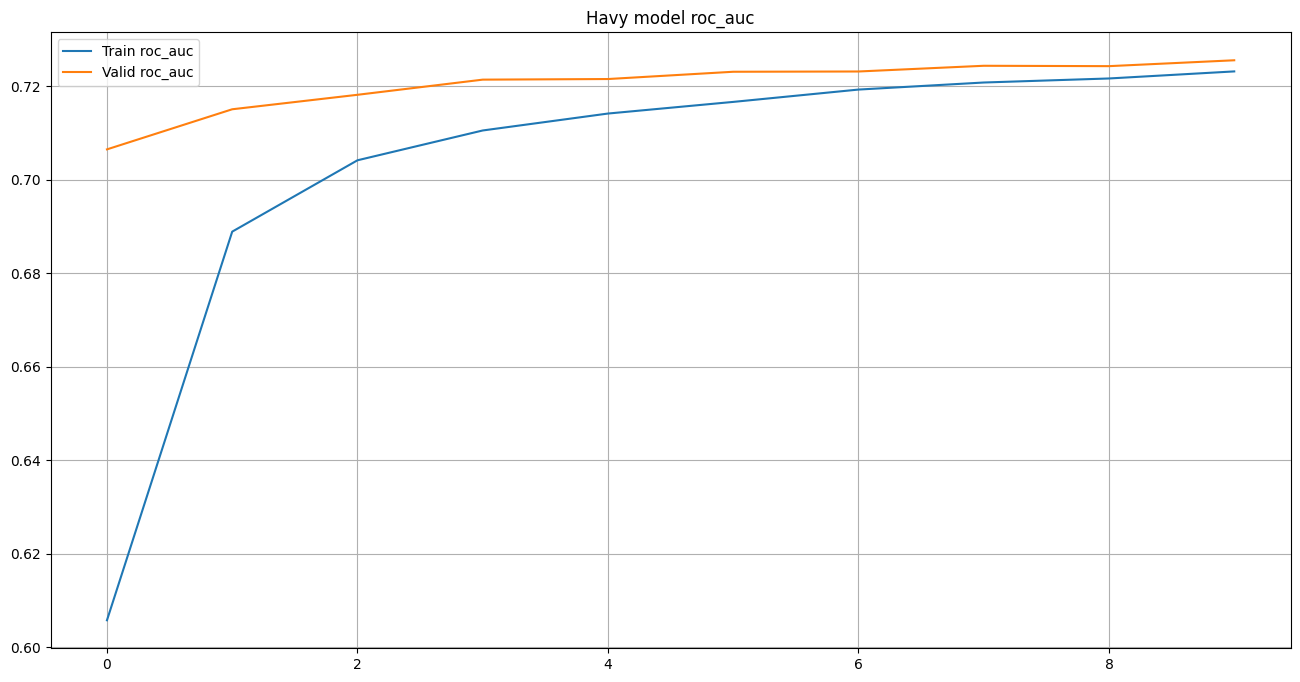

Epoch 10/10
Train ROC AUC: 0.7232
Valid ROC AUC: 0.7256
New best model saved.


In [17]:
class SmallerMLP(nn.Module):
    def __init__(self, input_dim, dropout=0.5):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(1)


train_dataset = FeatureDataset(train_data)
valid_dataset = FeatureDataset(val_data)


train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=2048, shuffle=False, num_workers=8, pin_memory=True)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.set_device(0)
else:
    device = 'cpu'
    
print(f"Using device: {device}")

print(device)
# print(torch.cuda.get_device_name())

pos_weight = torch.tensor([6.0], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

hidden_dim=2048
input_dim = len(train_dataset.feature_cols)
model = SmallerMLP(input_dim=input_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Device:", device)
print("Model is on:", next(model.parameters()).device)

whole_train_valid_cycle(model, 10, 'Havy model')

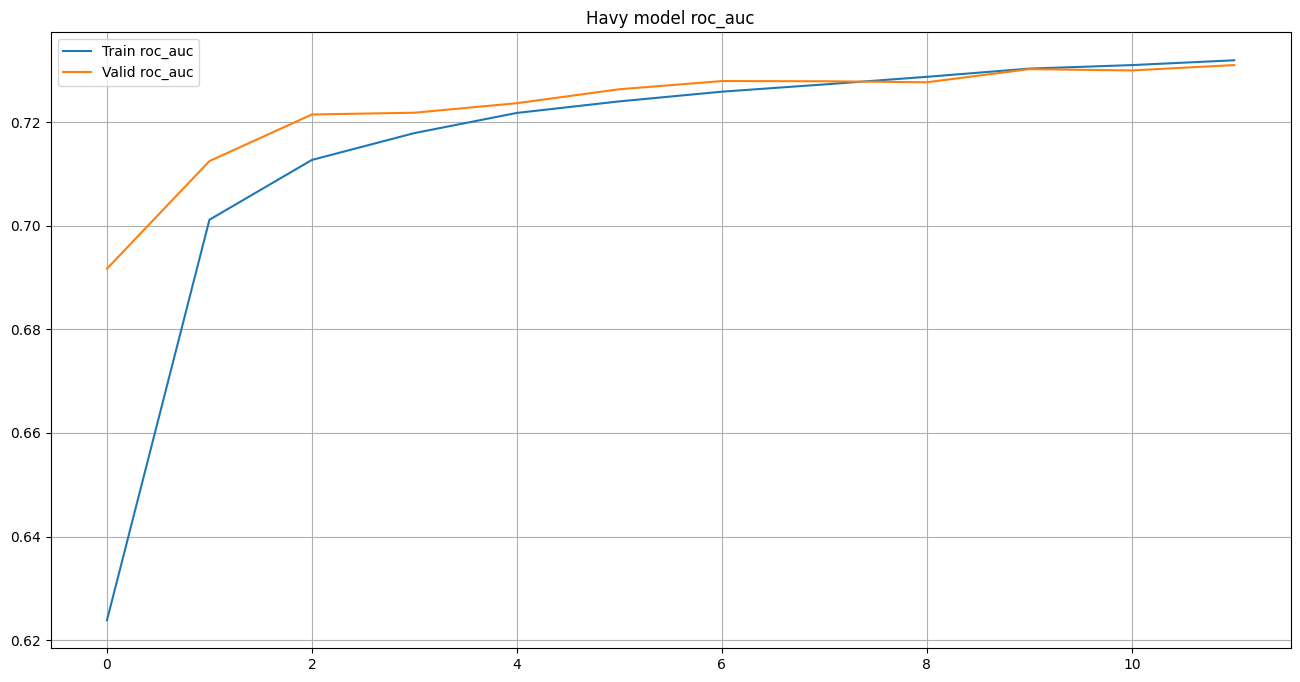

Epoch 12/12
Train ROC AUC: 0.7320
Valid ROC AUC: 0.7310
New best model saved.


In [12]:

class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, dropout=0.5):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 1)  # логиты без sigmoid
        )

    def forward(self, x):
        return self.model(x).squeeze(1)



train_dataset = FeatureDataset(train_data)
valid_dataset = FeatureDataset(val_data)


train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=2048, shuffle=False, num_workers=8, pin_memory=True)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.cuda.set_device(0)
else:
    device = 'cpu'
    
print(f"Using device: {device}")

print(device)
# print(torch.cuda.get_device_name())

pos_weight = torch.tensor([6.0], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

input_dim = len(train_dataset.feature_cols)
model = ImprovedMLP(input_dim=input_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

print("Device:", device)
print("Model is on:", next(model.parameters()).device)

whole_train_valid_cycle(model, 12, 'Havy model')

##

## Модель без DL

In [ ]:
post_features = pd.read_csv('/kaggle/input/features-dl/post_features_full_dl_0807.csv')
post_features.columns.to_list()

In [13]:
import glob

file_list = sorted(glob.glob("/kaggle/input/likes-months/likes_*.csv"))
likes = pd \
    .concat([pd.read_csv(file) for file in file_list], ignore_index=True)

print(likes.shape, likes.head())

(7362832, 2)    user_id  post_id
0   140626     1914
1   140626     1747
2   140626     4368
3   140626     6530
4   140626     2889


In [ ]:
!pip install lightfm


In [16]:
from lightfm import LightFM
from lightfm.data import Dataset

dataset = Dataset()
dataset.fit(likes['user_id'], likes['post_id'])

(interactions, _) = dataset.build_interactions(list(zip(likes['user_id'], likes['post_id'])))


In [17]:
model = LightFM(loss='warp')
model.fit(interactions, epochs=10, num_threads=2)

user_embeddings = model.get_user_representations()[1]  # матрица Num_users x dim
item_embeddings = model.get_item_representations()[1]  # матрица Num_posts x dim


In [18]:
user_id_map, _, post_id_map, _ = dataset.mapping()

user_id_inv_map = {v: k for k, v in user_id_map.items()}
post_id_inv_map = {v: k for k, v in post_id_map.items()}

user_df_fm = pd.DataFrame(user_embeddings)
user_df_fm['internal_id'] = user_df_fm.index
user_df_fm['user_id'] = user_df_fm['internal_id'].map(user_id_inv_map)
user_df_fm = user_df_fm.drop(columns='internal_id')

post_df_fm = pd.DataFrame(item_embeddings)
post_df_fm['internal_id'] = post_df_fm.index
post_df_fm['post_id'] = post_df_fm['internal_id'].map(post_id_inv_map)
post_df_fm = post_df_fm.drop(columns='internal_id')

user_embedding_cols = {i: f"user_fm_{i}" for i in range(user_df_fm.shape[1] - 1)}
user_df_fm = user_df_fm.rename(columns=user_embedding_cols)

# Переименуем эмбеддинги
post_embedding_cols = {i: f"post_fm_{i}" for i in range(post_df_fm.shape[1] - 1)}
post_df_fm = post_df_fm.rename(columns=post_embedding_cols)

print(post_df_fm.shape, user_df_fm.shape)

(6831, 11) (163199, 11)


In [19]:
user_df_fm.head()

,user_fm_0,user_fm_1,user_fm_2,user_fm_3,user_fm_4,user_fm_5,user_fm_6,user_fm_7,user_fm_8,user_fm_9,user_id
0,-0.424866,-0.293786,-0.393866,0.112393,-0.322763,-0.346032,0.170110,-0.553353,-0.106606,-0.104195,140626
1,0.160094,-0.046614,-0.114230,-0.466205,0.301231,0.262812,-0.061942,0.509921,0.045075,-0.252595,133983
2,0.395242,0.371557,0.330462,0.473670,0.341974,0.574497,0.033427,0.314334,0.062358,-0.024387,159945
3,-0.107170,-0.304614,0.142174,-0.219659,-0.197416,0.243188,-0.083657,0.140666,-0.299047,0.013260,147524
4,-0.102597,0.022256,-0.140209,-0.257722,0.185457,-0.699788,-0.242278,-0.313686,-0.328594,-0.042799,49826


In [11]:
no_dl_col = [
    'user_id',
     'post_id',
     'target',
     'weekday',
     'hour',
     'gender',
     'age',
     'avg_log_word_len',
     'max_log_word_len',
     'movie_likes_rate',
     'business_likes_rate',
     'covid_likes_rate',
     'sport_likes_rate',
     'politics_likes_rate',
     'tech_likes_rate',
     'views_per_day',
     'likes_per_day',
     'country_Belarus',
     'country_Cyprus',
     'country_Estonia',
     'country_Finland',
     'country_Kazakhstan',
     'country_Latvia',
     'country_Russia',
     'country_Switzerland',
     'country_Turkey',
     'country_Ukraine',
     'exp_group_1',
     'exp_group_2',
     'exp_group_3',
     'exp_group_4',
     'city_freq',
     'log_text_len',
     'n_words',
     'avg_word_len',
     'like_count_log',
     'like_rank',
     'like_score',
     'tfidf_0',
     'tfidf_1',
     'tfidf_2',
     'tfidf_3',
     'tfidf_4',
     'tfidf_5',
     'tfidf_6',
     'tfidf_7',
     'tfidf_8',
     'tfidf_9',
     'tfidf_10',
     'tfidf_11',
     'tfidf_12',
     'tfidf_13',
     'tfidf_14',
     'tfidf_15',
     'tfidf_16',
     'tfidf_17',
     'tfidf_18',
     'tfidf_19',
     'tfidf_20',
     'tfidf_21',
     'tfidf_22',
     'tfidf_23',
     'tfidf_24',
     'tfidf_25',
     'tfidf_26',
     'tfidf_27',
     'tfidf_28',
     'tfidf_29',
     'tfidf_30',
     'tfidf_31',
     'tfidf_32',
     'tfidf_33',
     'tfidf_34',
     'tfidf_35',
     'tfidf_36',
     'tfidf_37',
     'tfidf_38',
     'tfidf_39',
     'tfidf_40',
     'tfidf_41',
     'tfidf_42',
     'tfidf_43',
     'tfidf_44',
     'tfidf_45',
     'tfidf_46',
     'tfidf_47',
     'tfidf_48',
     'tfidf_49',
     'tfidf_50',
     'tfidf_51',
     'tfidf_52',
     'tfidf_53',
     'tfidf_54',
     'tfidf_55',
     'tfidf_56',
     'tfidf_57',
     'tfidf_58',
     'tfidf_59',
     'tfidf_60',
     'tfidf_61',
     'tfidf_62',
     'tfidf_63',
     'tfidf_64',
     'tfidf_65',
     'tfidf_66',
     'tfidf_67',
     'tfidf_68',
     'tfidf_69',
     'tfidf_70',
     'tfidf_71',
     'tfidf_72',
     'tfidf_73',
     'tfidf_74',
     'tfidf_75',
     'tfidf_76',
     'tfidf_77',
     'tfidf_78',
     'tfidf_79',
     'tfidf_80',
     'tfidf_81',
     'tfidf_82',
     'tfidf_83',
     'tfidf_84',
     'tfidf_85',
     'tfidf_86',
     'tfidf_87',
     'tfidf_88',
     'tfidf_89',
     'tfidf_90',
     'tfidf_91',
     'tfidf_92',
     'tfidf_93',
     'tfidf_94',
     'tfidf_95',
     'tfidf_96',
     'tfidf_97',
     'tfidf_98',
     'tfidf_99',
     'topic_covid',
     'topic_entertainment',
     'topic_movie',
     'topic_politics',
     'topic_sport',
     'topic_tech'
]

In [25]:
train_data_no_dl = train_data[no_dl_col].merge(
                                          user_df_fm, how='left', on = 'user_id'  
                                       ).merge(
                                          post_df_fm, how='left', on = 'post_id'  
                                       )
train_data_no_dl.columns

Index(['user_id', 'post_id', 'target', 'weekday', 'hour', 'gender', 'age',
       'avg_log_word_len', 'max_log_word_len', 'movie_likes_rate',
       ...
       'post_fm_0', 'post_fm_1', 'post_fm_2', 'post_fm_3', 'post_fm_4',
       'post_fm_5', 'post_fm_6', 'post_fm_7', 'post_fm_8', 'post_fm_9'],
      dtype='object', length=164)

In [26]:
val_data_no_dl = val_data[no_dl_col].merge(
                                          user_df_fm, how='left', on = 'user_id'  
                                       ).merge(
                                          post_df_fm, how='left', on = 'post_id'  
                                       )
val_data_no_dl.shape

(1000000, 164)

In [12]:
val_data_no_dl = val_data[no_dl_col]
train_data_no_dl = train_data[no_dl_col]

In [30]:
train_data_no_dl.columns.to_list()

['user_id',
 'post_id',
 'target',
 'weekday',
 'hour',
 'gender',
 'age',
 'avg_log_word_len',
 'max_log_word_len',
 'movie_likes_rate',
 'business_likes_rate',
 'covid_likes_rate',
 'sport_likes_rate',
 'politics_likes_rate',
 'tech_likes_rate',
 'views_per_day',
 'likes_per_day',
 'country_Belarus',
 'country_Cyprus',
 'country_Estonia',
 'country_Finland',
 'country_Kazakhstan',
 'country_Latvia',
 'country_Russia',
 'country_Switzerland',
 'country_Turkey',
 'country_Ukraine',
 'exp_group_1',
 'exp_group_2',
 'exp_group_3',
 'exp_group_4',
 'city_freq',
 'log_text_len',
 'n_words',
 'avg_word_len',
 'like_count_log',
 'like_rank',
 'like_score',
 'tfidf_0',
 'tfidf_1',
 'tfidf_2',
 'tfidf_3',
 'tfidf_4',
 'tfidf_5',
 'tfidf_6',
 'tfidf_7',
 'tfidf_8',
 'tfidf_9',
 'tfidf_10',
 'tfidf_11',
 'tfidf_12',
 'tfidf_13',
 'tfidf_14',
 'tfidf_15',
 'tfidf_16',
 'tfidf_17',
 'tfidf_18',
 'tfidf_19',
 'tfidf_20',
 'tfidf_21',
 'tfidf_22',
 'tfidf_23',
 'tfidf_24',
 'tfidf_25',
 'tfidf_26',


In [14]:
from catboost import CatBoostClassifier, Pool

X_train = train_data_no_dl.drop(['target'], axis=1).set_index(['user_id', 'post_id'])
y_train = train_data['target']

X_valid = val_data_no_dl.drop(['target'], axis=1).set_index(['user_id', 'post_id'])
y_valid = val_data['target']

model = CatBoostClassifier(
    depth=7,                     
    iterations=1500,              
    learning_rate=0.1,          
    verbose=100,                  
    loss_function='Logloss',
    eval_metric='Logloss',          
    scale_pos_weight=6,          
    early_stopping_rounds=50,   
    l2_leaf_reg=5,               
    random_strength=3,           
    bagging_temperature=0.5,     
    task_type="GPU"      
)

train_pool = Pool(data=X_train, label=y_train)
valid_pool = Pool(data=X_valid, label=y_valid)

model.fit(train_pool, eval_set=valid_pool)

auc = calculate_auc(model, X_valid, y_valid)
hit5 = calculate_hit_rate_by_user(model, X_valid, y_valid)

print(f'auc {auc}, hit5 {hit5}')

0:	learn: 0.6651356	test: 0.6646180	best: 0.6646180 (0)	total: 246ms	remaining: 6m 8s
100:	learn: 0.5452609	test: 0.5444806	best: 0.5444806 (100)	total: 3.99s	remaining: 55.2s
200:	learn: 0.5363946	test: 0.5372075	best: 0.5370214 (198)	total: 7.56s	remaining: 48.9s
300:	learn: 0.5327118	test: 0.5354991	best: 0.5354991 (300)	total: 11.2s	remaining: 44.4s
400:	learn: 0.5301251	test: 0.5349375	best: 0.5349365 (371)	total: 14.9s	remaining: 40.8s
bestTest = 0.5349365005
bestIteration = 371
Shrink model to first 372 iterations.
auc 0.7730359438108463, hit5 0.6116614271309093


In [16]:
model.save_model("no_dl_catboost_model_16_07.cbm")

In [17]:
import os
print(os.path.exists("no_dl_catboost_model_16_07.cbm"))


True


In [32]:
post_features = pd.read_csv('/kaggle/input/features-dl/post_features_full_dl_0807.csv')
user_features = pd.read_csv('/kaggle/input/features-dl/user_features_full_dl_0807.csv')

In [33]:
post_features = post_features.merge(
    post_df_fm, how='left', on = 'post_id'
)

user_features = user_features.merge(
    user_df_fm, how='left', on = 'user_id'
)

In [34]:
post_features.to_csv('post_features_full_15_7.csv')
user_features.to_csv('user_features_full_15_7.csv')

In [36]:
no_dl_features = model.feature_names_

model.featuere_names_

In [39]:
user_f_no_dl = ['user_id'] + [col for col in user_features if col in no_dl_features]
user_f_no_dl

['user_id',
 'gender',
 'age',
 'avg_log_word_len',
 'max_log_word_len',
 'movie_likes_rate',
 'business_likes_rate',
 'covid_likes_rate',
 'sport_likes_rate',
 'politics_likes_rate',
 'tech_likes_rate',
 'views_per_day',
 'likes_per_day',
 'country_Belarus',
 'country_Cyprus',
 'country_Estonia',
 'country_Finland',
 'country_Kazakhstan',
 'country_Latvia',
 'country_Russia',
 'country_Switzerland',
 'country_Turkey',
 'country_Ukraine',
 'exp_group_1',
 'exp_group_2',
 'exp_group_3',
 'exp_group_4',
 'city_freq',
 'user_fm_0',
 'user_fm_1',
 'user_fm_2',
 'user_fm_3',
 'user_fm_4',
 'user_fm_5',
 'user_fm_6',
 'user_fm_7',
 'user_fm_8',
 'user_fm_9']

In [40]:
post_f_no_dl = ['post_id'] + [col for col in post_features if col in no_dl_features]
post_f_no_dl

['post_id',
 'log_text_len',
 'n_words',
 'avg_word_len',
 'like_count_log',
 'like_rank',
 'like_score',
 'tfidf_0',
 'tfidf_1',
 'tfidf_2',
 'tfidf_3',
 'tfidf_4',
 'tfidf_5',
 'tfidf_6',
 'tfidf_7',
 'tfidf_8',
 'tfidf_9',
 'tfidf_10',
 'tfidf_11',
 'tfidf_12',
 'tfidf_13',
 'tfidf_14',
 'tfidf_15',
 'tfidf_16',
 'tfidf_17',
 'tfidf_18',
 'tfidf_19',
 'tfidf_20',
 'tfidf_21',
 'tfidf_22',
 'tfidf_23',
 'tfidf_24',
 'tfidf_25',
 'tfidf_26',
 'tfidf_27',
 'tfidf_28',
 'tfidf_29',
 'tfidf_30',
 'tfidf_31',
 'tfidf_32',
 'tfidf_33',
 'tfidf_34',
 'tfidf_35',
 'tfidf_36',
 'tfidf_37',
 'tfidf_38',
 'tfidf_39',
 'tfidf_40',
 'tfidf_41',
 'tfidf_42',
 'tfidf_43',
 'tfidf_44',
 'tfidf_45',
 'tfidf_46',
 'tfidf_47',
 'tfidf_48',
 'tfidf_49',
 'tfidf_50',
 'tfidf_51',
 'tfidf_52',
 'tfidf_53',
 'tfidf_54',
 'tfidf_55',
 'tfidf_56',
 'tfidf_57',
 'tfidf_58',
 'tfidf_59',
 'tfidf_60',
 'tfidf_61',
 'tfidf_62',
 'tfidf_63',
 'tfidf_64',
 'tfidf_65',
 'tfidf_66',
 'tfidf_67',
 'tfidf_68',
 'tfidf

In [18]:
from catboost import CatBoostClassifier, Pool

model_dl = CatBoostClassifier()
model_dl.load_model('/kaggle/input/cb_1407/other/default/1/best_catboost_model_14_7.cbm')

In [19]:
dl_features = model_dl.feature_names_

In [43]:
user_f_dl = ['user_id'] + [col for col in user_features if col in dl_features]
user_f_dl

['user_id',
 'gender',
 'age',
 'avg_log_word_len',
 'max_log_word_len',
 'movie_likes_rate',
 'business_likes_rate',
 'covid_likes_rate',
 'sport_likes_rate',
 'politics_likes_rate',
 'tech_likes_rate',
 'views_per_day',
 'likes_per_day',
 'country_Belarus',
 'country_Cyprus',
 'country_Estonia',
 'country_Finland',
 'country_Kazakhstan',
 'country_Latvia',
 'country_Russia',
 'country_Switzerland',
 'country_Turkey',
 'country_Ukraine',
 'exp_group_1',
 'exp_group_2',
 'exp_group_3',
 'exp_group_4',
 'city_freq',
 'user_emb_0',
 'user_emb_1',
 'user_emb_2',
 'user_emb_3',
 'user_emb_4',
 'user_emb_5',
 'user_emb_6',
 'user_emb_7',
 'user_emb_8',
 'user_emb_9',
 'user_emb_10',
 'user_emb_11',
 'user_emb_12',
 'user_emb_13',
 'user_emb_14',
 'user_emb_15',
 'user_emb_16',
 'user_emb_17',
 'user_emb_18',
 'user_emb_19',
 'user_emb_20',
 'user_emb_21',
 'user_emb_22',
 'user_emb_23',
 'user_emb_24',
 'user_emb_25',
 'user_emb_26',
 'user_emb_27',
 'user_emb_28',
 'user_emb_29',
 'user_em

In [44]:
post_f_dl = ['post_id'] + [col for col in post_features if col in dl_features]
print(post_f_dl)

['post_id',
 'log_text_len',
 'n_words',
 'avg_word_len',
 'svd_0',
 'svd_1',
 'svd_2',
 'svd_3',
 'svd_4',
 'svd_5',
 'svd_6',
 'svd_7',
 'svd_8',
 'svd_9',
 'svd_10',
 'svd_11',
 'svd_12',
 'svd_13',
 'svd_14',
 'svd_15',
 'svd_16',
 'svd_17',
 'svd_18',
 'svd_19',
 'svd_20',
 'svd_21',
 'svd_22',
 'svd_23',
 'svd_24',
 'svd_25',
 'svd_26',
 'svd_27',
 'svd_28',
 'svd_29',
 'svd_30',
 'svd_31',
 'svd_32',
 'svd_33',
 'svd_34',
 'svd_35',
 'svd_36',
 'svd_37',
 'svd_38',
 'svd_39',
 'svd_40',
 'svd_41',
 'svd_42',
 'svd_43',
 'svd_44',
 'svd_45',
 'svd_46',
 'svd_47',
 'svd_48',
 'svd_49',
 'svd_50',
 'svd_51',
 'svd_52',
 'svd_53',
 'svd_54',
 'svd_55',
 'svd_56',
 'svd_57',
 'svd_58',
 'svd_59',
 'svd_60',
 'svd_61',
 'svd_62',
 'svd_63',
 'svd_64',
 'svd_65',
 'svd_66',
 'svd_67',
 'svd_68',
 'svd_69',
 'svd_70',
 'svd_71',
 'svd_72',
 'svd_73',
 'svd_74',
 'svd_75',
 'svd_76',
 'svd_77',
 'svd_78',
 'svd_79',
 'svd_80',
 'svd_81',
 'svd_82',
 'svd_83',
 'svd_84',
 'svd_85',
 'svd_

In [48]:
print(post_f_no_dl)

['post_id', 'log_text_len', 'n_words', 'avg_word_len', 'like_count_log', 'like_rank', 'like_score', 'tfidf_0', 'tfidf_1', 'tfidf_2', 'tfidf_3', 'tfidf_4', 'tfidf_5', 'tfidf_6', 'tfidf_7', 'tfidf_8', 'tfidf_9', 'tfidf_10', 'tfidf_11', 'tfidf_12', 'tfidf_13', 'tfidf_14', 'tfidf_15', 'tfidf_16', 'tfidf_17', 'tfidf_18', 'tfidf_19', 'tfidf_20', 'tfidf_21', 'tfidf_22', 'tfidf_23', 'tfidf_24', 'tfidf_25', 'tfidf_26', 'tfidf_27', 'tfidf_28', 'tfidf_29', 'tfidf_30', 'tfidf_31', 'tfidf_32', 'tfidf_33', 'tfidf_34', 'tfidf_35', 'tfidf_36', 'tfidf_37', 'tfidf_38', 'tfidf_39', 'tfidf_40', 'tfidf_41', 'tfidf_42', 'tfidf_43', 'tfidf_44', 'tfidf_45', 'tfidf_46', 'tfidf_47', 'tfidf_48', 'tfidf_49', 'tfidf_50', 'tfidf_51', 'tfidf_52', 'tfidf_53', 'tfidf_54', 'tfidf_55', 'tfidf_56', 'tfidf_57', 'tfidf_58', 'tfidf_59', 'tfidf_60', 'tfidf_61', 'tfidf_62', 'tfidf_63', 'tfidf_64', 'tfidf_65', 'tfidf_66', 'tfidf_67', 'tfidf_68', 'tfidf_69', 'tfidf_70', 'tfidf_71', 'tfidf_72', 'tfidf_73', 'tfidf_74', 'tfidf_75'

In [26]:
dl_features_red = ['user_id', 'post_id', 'weekday',
 'hour',
 'gender',
 'age',
 'avg_log_word_len',
 'max_log_word_len',
 'movie_likes_rate',
 'business_likes_rate',
 'covid_likes_rate',
 'sport_likes_rate',
 'politics_likes_rate',
 'tech_likes_rate',
 'views_per_day',
 'likes_per_day',
 'country_Belarus',
 'country_Cyprus',
 'country_Estonia',
 'country_Finland',
 'country_Kazakhstan',
 'country_Latvia',
 'country_Russia',
 'country_Switzerland',
 'country_Turkey',
 'country_Ukraine',
 'exp_group_1',
 'exp_group_2',
 'exp_group_3',
 'exp_group_4',
 'city_freq',
 'user_emb_0',
 'user_emb_1',
 'user_emb_2',
 'user_emb_3',
 'user_emb_4',
 'user_emb_5',
 'user_emb_6',
 'user_emb_7',
 'user_emb_8',
 'user_emb_9',
 'user_emb_10',
 'user_emb_11',
 'user_emb_12',
 'user_emb_13',
 'user_emb_14',
 'user_emb_15',
 'user_emb_16',
 'user_emb_17',
 'user_emb_18',
 'user_emb_19',
 'user_emb_20',
 'user_emb_21',
 'user_emb_22',
 'user_emb_23',
 'user_emb_24',
 'user_emb_25',
 'user_emb_26',
 'user_emb_27',
 'user_emb_28',
 'user_emb_29',
 'user_emb_30',
 'user_emb_31',
 'user_emb_32',
 'user_emb_33',
 'user_emb_34',
 'user_emb_35',
 'user_emb_36',
 'user_emb_37',
 'user_emb_38',
 'user_emb_39',
 'user_emb_40',
 'user_emb_41',
 'user_emb_42',
 'user_emb_43',
 'user_emb_44',
 'user_emb_45',
 'user_emb_46',
 'user_emb_47',
 'user_emb_48',
 'user_emb_49',
 'user_emb_50',
 'user_emb_51',
 'user_emb_52',
 'user_emb_53',
 'user_emb_54',
 'user_emb_55',
 'user_emb_56',
 'user_emb_57',
 'user_emb_58',
 'user_emb_59',
 'user_emb_60',
 'user_emb_61',
 'user_emb_62',
 'user_emb_63',
 'log_text_len',
 'n_words',
 'avg_word_len',
 'like_count_log',
 'like_rank',
 'like_score',
 'tfidf_0',
 'tfidf_1',
 'tfidf_2',
 'tfidf_3',
 'tfidf_4',
 'tfidf_5',
 'tfidf_6',
 'tfidf_7',
 'tfidf_8',
 'tfidf_9',
 'tfidf_10',
 'tfidf_11',
 'tfidf_12',
 'tfidf_13',
 'tfidf_14',
 'tfidf_15',
 'tfidf_16',
 'tfidf_17',
 'tfidf_18',
 'tfidf_19',
 'tfidf_20',
 'tfidf_21',
 'tfidf_22',
 'tfidf_23',
 'tfidf_24',
 'tfidf_25',
 'tfidf_26',
 'tfidf_27',
 'tfidf_28',
 'tfidf_29',
 'tfidf_30',
 'tfidf_31',
 'tfidf_32',
 'tfidf_33',
 'tfidf_34',
 'tfidf_35',
 'tfidf_36',
 'tfidf_37',
 'tfidf_38',
 'tfidf_39',
 'tfidf_40',
 'tfidf_41',
 'tfidf_42',
 'tfidf_43',
 'tfidf_44',
 'tfidf_45',
 'tfidf_46',
 'tfidf_47',
 'tfidf_48',
 'tfidf_49',
 'tfidf_50',
 'tfidf_51',
 'tfidf_52',
 'tfidf_53',
 'tfidf_54',
 'tfidf_55',
 'tfidf_56',
 'tfidf_57',
 'tfidf_58',
 'tfidf_59',
 'tfidf_60',
 'tfidf_61',
 'tfidf_62',
 'tfidf_63',
 'tfidf_64',
 'tfidf_65',
 'tfidf_66',
 'tfidf_67',
 'tfidf_68',
 'tfidf_69',
 'tfidf_70',
 'tfidf_71',
 'tfidf_72',
 'tfidf_73',
 'tfidf_74',
 'tfidf_75',
 'tfidf_76',
 'tfidf_77',
 'tfidf_78',
 'tfidf_79',
 'tfidf_80',
 'tfidf_81',
 'tfidf_82',
 'tfidf_83',
 'tfidf_84',
 'tfidf_85',
 'tfidf_86',
 'tfidf_87',
 'tfidf_88',
 'tfidf_89',
 'tfidf_90',
 'tfidf_91',
 'tfidf_92',
 'tfidf_93',
 'tfidf_94',
 'tfidf_95',
 'tfidf_96',
 'tfidf_97',
 'tfidf_98',
 'tfidf_99',
 'topic_covid',
 'topic_entertainment',
 'topic_movie',
 'topic_politics',
 'topic_sport',
 'topic_tech',
 'item_emb_0',
 'item_emb_1',
 'item_emb_2',
 'item_emb_3',
 'item_emb_4',
 'item_emb_5',
 'item_emb_6',
 'item_emb_7',
 'item_emb_8',
 'item_emb_9',
 'item_emb_10',
 'item_emb_11',
 'item_emb_12',
 'item_emb_13',
 'item_emb_14',
 'item_emb_15',
 'item_emb_16',
 'item_emb_17',
 'item_emb_18',
 'item_emb_19',
 'item_emb_20',
 'item_emb_21',
 'item_emb_22',
 'item_emb_23',
 'item_emb_24',
 'item_emb_25',
 'item_emb_26',
 'item_emb_27',
 'item_emb_28',
 'item_emb_29',
 'item_emb_30',
 'item_emb_31',
 'item_emb_32',
 'item_emb_33',
 'item_emb_34',
 'item_emb_35',
 'item_emb_36',
 'item_emb_37',
 'item_emb_38',
 'item_emb_39',
 'item_emb_40',
 'item_emb_41',
 'item_emb_42',
 'item_emb_43',
 'item_emb_44',
 'item_emb_45',
 'item_emb_46',
 'item_emb_47',
 'item_emb_48',
 'item_emb_49',
 'item_emb_50',
 'item_emb_51',
 'item_emb_52',
 'item_emb_53',
 'item_emb_54',
 'item_emb_55',
 'item_emb_56',
 'item_emb_57',
 'item_emb_58',
 'item_emb_59',
 'item_emb_60',
 'item_emb_61',
 'item_emb_62',
 'item_emb_63',
'target']

In [27]:
train_data_red = train_data[dl_features_red]
val_data_red = val_data[dl_features_red]

X_train = train_data_red.drop(['target'], axis=1).set_index(['user_id', 'post_id'])
y_train = train_data_red['target']

X_valid = val_data_red.drop(['target'], axis=1).set_index(['user_id', 'post_id'])
y_valid = val_data_red['target']


train_pool = Pool(data=X_train, label=y_train)
valid_pool = Pool(data=X_valid, label=y_valid)

model_dl.fit(train_pool, eval_set=valid_pool)

auc = calculate_auc(model_dl, X_valid, y_valid)
hit5 = calculate_hit_rate_by_user(model_dl, X_valid, y_valid)

print(f'auc {auc}, hit5 {hit5}')

0:	learn: 0.6334013	test: 0.6322875	best: 0.6322875 (0)	total: 126ms	remaining: 3m 8s
100:	learn: 0.5218518	test: 0.5224376	best: 0.5224376 (100)	total: 6.15s	remaining: 1m 25s
200:	learn: 0.5078400	test: 0.5113857	best: 0.5113857 (200)	total: 12.6s	remaining: 1m 21s
300:	learn: 0.4970286	test: 0.5029585	best: 0.5029585 (300)	total: 19.3s	remaining: 1m 16s
400:	learn: 0.4888813	test: 0.4971171	best: 0.4971171 (400)	total: 25.8s	remaining: 1m 10s
500:	learn: 0.4823573	test: 0.4927483	best: 0.4927483 (500)	total: 32.2s	remaining: 1m 4s
600:	learn: 0.4765993	test: 0.4896937	best: 0.4896937 (600)	total: 38.5s	remaining: 57.5s
700:	learn: 0.4717609	test: 0.4874994	best: 0.4874994 (700)	total: 44.6s	remaining: 50.8s
800:	learn: 0.4675253	test: 0.4866258	best: 0.4866258 (800)	total: 50.7s	remaining: 44.3s
900:	learn: 0.4635523	test: 0.4860326	best: 0.4860326 (900)	total: 57s	remaining: 37.9s
1000:	learn: 0.4597131	test: 0.4857157	best: 0.4857063 (994)	total: 1m 3s	remaining: 31.5s
bestTest = 

In [28]:
model_dl.save_model("best_catboost_model_16_7.cbm")

In [31]:
model.feature_names_

['weekday',
 'hour',
 'gender',
 'age',
 'avg_log_word_len',
 'max_log_word_len',
 'movie_likes_rate',
 'business_likes_rate',
 'covid_likes_rate',
 'sport_likes_rate',
 'politics_likes_rate',
 'tech_likes_rate',
 'views_per_day',
 'likes_per_day',
 'country_Belarus',
 'country_Cyprus',
 'country_Estonia',
 'country_Finland',
 'country_Kazakhstan',
 'country_Latvia',
 'country_Russia',
 'country_Switzerland',
 'country_Turkey',
 'country_Ukraine',
 'exp_group_1',
 'exp_group_2',
 'exp_group_3',
 'exp_group_4',
 'city_freq',
 'log_text_len',
 'n_words',
 'avg_word_len',
 'like_count_log',
 'like_rank',
 'like_score',
 'tfidf_0',
 'tfidf_1',
 'tfidf_2',
 'tfidf_3',
 'tfidf_4',
 'tfidf_5',
 'tfidf_6',
 'tfidf_7',
 'tfidf_8',
 'tfidf_9',
 'tfidf_10',
 'tfidf_11',
 'tfidf_12',
 'tfidf_13',
 'tfidf_14',
 'tfidf_15',
 'tfidf_16',
 'tfidf_17',
 'tfidf_18',
 'tfidf_19',
 'tfidf_20',
 'tfidf_21',
 'tfidf_22',
 'tfidf_23',
 'tfidf_24',
 'tfidf_25',
 'tfidf_26',
 'tfidf_27',
 'tfidf_28',
 'tfidf_2

bestTest = 0.4866065023  
bestIteration = 1061  
Shrink model to first 1062 iterations.  
auc 0.811718168516973, hit5 0.7044308677857524  